__семантический сегментатор изображений__

Евгений Борисов  <esborisov@sevsu.ru>

---

Fully Convolutional Networks for Semantic Segmentation  
Jonathan Long, Evan Shelhamer, Trevor Darrell  
UC Berkeley  
8 Mar 2015  

https://arxiv.org/pdf/1411.4038.pdf

https://github.com/YunYang1994/TensorFlow2.0-Examples/tree/master/5-Image_Segmentation/FCN

In [1]:
# from IPython.core.interactiveshell import InteractiveShell
# InteractiveShell.ast_node_interactivity = "all"

In [2]:
import gc
from os.path import join as pjoin
import numpy as np
import matplotlib.pyplot as plt
# from matplotlib import cm

In [3]:
from tabulate import tabulate
import tensorflow as tf
from tensorflow.test import is_built_with_cuda
from tensorflow.python.client.device_lib import list_local_devices

def tf_info(tablefmt='html'):
    res = [ ['tensorflow','%s'%(tf.__version__)],['keras','%s'%(tf.keras.__version__)] ]
    if is_built_with_cuda():
        res.extend( [ 
              [ s.strip().split(': ') for s in d.physical_device_desc.split(',')  ]
               for d in list_local_devices() 
              if d.device_type == 'GPU' # and d.name==tf.test.gpu_device_name()
            ][0] )
    else:
        res.append(['','no CUDA support'])
    return tabulate( res, tablefmt=tablefmt )

tf_info()

tensorflow,2.4.1
keras,2.4.0
device,0
name,NVIDIA GeForce GTX 1060 6GB
pci bus id,0000:01:00.0
compute capability,6.1


---

In [4]:
!mkdir -p result/fcn

In [5]:
FOLDER_DATA = 'data/pascal_my'
FOLDER_RESULT = 'result/fcn'

## загружаем данные

In [6]:
x_train = np.load(pjoin(FOLDER_DATA,'x_train.npy'))
x_train.shape

(3335, 256, 256, 3)

In [7]:
y_train = np.load(pjoin(FOLDER_DATA,'y_train.npy'))
y_train.shape

(3335, 256, 256)

In [8]:
gc.collect()

97

---

In [9]:
# сводим задачу к бинарной классификации

# выбираем класс с максимальным количеством примеров
n,w,h = y_train.shape
n_samples_class = [ (y_train.reshape(n,w*h)==c+1).any(axis=-1).sum() for c in range(y_train.max()) ]
n_samples_class_max = np.argmax(n_samples_class)+1

# n_samples_class_max,n_samples_class[n_samples_class_max-1],n_samples_class

# выбираем примеры с найденным номером класса
y_train_mono = (y_train==n_samples_class_max)
y_train_mono_label = y_train_mono.any(axis=-1).any(axis=-1)


x_train_mono = x_train[y_train_mono_label,:]
y_train_mono = y_train_mono[y_train_mono_label,:].astype(np.uint8)

n_class=2

x_train_mono.shape, y_train_mono.shape

((1059, 256, 256, 3), (1059, 256, 256))

In [10]:
x_train_mono.min(),x_train_mono.max(),  y_train_mono.min(),y_train_mono.max()

(-2.117904, 2.64, 0, 1)

In [11]:
x_train,y_train = x_train_mono, y_train_mono

In [12]:
gc.collect()

45

## строим модель

In [15]:
class FCN8s(tf.keras.Model):
    
    def __init__(self, n_class=21):
        super(FCN8s, self).__init__()
        # conv1
        self.conv1_1 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='valid')
        self.conv1_2 = tf.keras.layers.Conv2D(64, 3, activation='relu', padding='same')
        self.pool1   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/2

        # conv2
        self.conv2_1 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.conv2_2 = tf.keras.layers.Conv2D(128, 3, activation='relu', padding='same')
        self.pool2   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/4

        # conv3
        self.conv3_1 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_2 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.conv3_3 = tf.keras.layers.Conv2D(256, 3, activation='relu', padding='same')
        self.pool3   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/8

        # conv4
        self.conv4_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv4_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool4   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/16

        # conv5
        self.conv5_1 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_2 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.conv5_3 = tf.keras.layers.Conv2D(512, 3, activation='relu', padding='same')
        self.pool5   = tf.keras.layers.MaxPooling2D(2, strides=2, padding='same') # 1/32

        # fc6
        self.fc6 = tf.keras.layers.Conv2D(4096, 7, activation='relu', padding='valid')
        self.drop6 = tf.keras.layers.Dropout(0.5)

        # fc7
        self.fc7 = tf.keras.layers.Conv2D(4096, 1, activation='relu', padding='valid')
        self.drop7 = tf.keras.layers.Dropout(0.5)

        self.socre_fr = tf.keras.layers.Conv2D(n_class, 1)
        self.score_pool3 = tf.keras.layers.Conv2D(n_class, 1)
        self.score_pool4 = tf.keras.layers.Conv2D(n_class, 1)

        self.upscore2 = tf.keras.layers.Conv2DTranspose(n_class,4,strides=2,padding='valid',use_bias=False)
        self.upscore8 = tf.keras.layers.Conv2DTranspose(n_class,16,strides=8,padding='valid',use_bias=False)
        self.upscore_pool4 = tf.keras.layers.Conv2DTranspose(n_class,4,strides=2,padding='valid',use_bias=False)

        # https://datascience.stackexchange.com/questions/6107/what-are-deconvolutional-layers
        # https://slideplayer.com/slide/15353689/92/images/5/Transposed+Convolution+%28Deconvolution%29.jpg
        
    def call(self, x, training=False):
        h = x
        h = self.conv1_1(tf.keras.layers.ZeroPadding2D(padding=(100,100))(h))
        h = self.conv1_2(h)
        h = self.pool1(h)

        h = self.conv2_1(h)
        h = self.conv2_2(h)
        h = self.pool2(h)

        h = self.conv3_1(h)
        h = self.conv3_2(h)
        h = self.conv3_3(h)
        h = self.pool3(h)
        pool3 = h # 1/8

        h = self.conv4_1(h)
        h = self.conv4_2(h)
        h = self.conv4_3(h)
        h = self.pool4(h)
        pool4 = h # 1/16

        h = self.conv5_1(h)
        h = self.conv5_2(h)
        h = self.conv5_3(h)
        h = self.pool5(h)

        h = self.fc6(h)
        h = self.drop6(h, training)

        h = self.fc7(h)
        h = self.drop7(h, training)

        h = self.socre_fr(h)
        h = self.upscore2(h)
        upscore2 = h # 1/16
        # print(upscore2.shape)

        h = self.score_pool4(pool4 * 0.01) # XXX: scaling to train at onece
        h = h[:, 5:5+upscore2.shape[1], 5:5+upscore2.shape[2], :] # channel last
        score_pool4c = h # 1/16

        h = upscore2 + score_pool4c # 1/16
        h = self.upscore_pool4(h)
        upscore_pool4 = h # 1/8

        h = self.score_pool3(pool3 * 0.0001) # XXX: scaling to train at onece
        h = h[:, 9:9+upscore_pool4.shape[1], 9:9+upscore_pool4.shape[2], :] # channel last
        score_pool3c = h # 1/8

        h = upscore_pool4 + score_pool3c # 1/8

        h = self.upscore8(h)
        h = h[:, 31:31+x.shape[1], 31:31+x.shape[2], :] # channel last

        return tf.nn.softmax(h, axis=-1)

## обучаем модель

In [16]:
BATCH_SIZE = 8
LEARNING_RATE = 1e-4

model = FCN8s(n_class=n_class)
optimizer=tf.keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(optimizer=optimizer, loss='sparse_categorical_crossentropy',  metrics=['accuracy'])

In [20]:
%%time 

model.fit(x_train,y_train, batch_size=BATCH_SIZE, epochs=100)

Epoch 1/100
133/133 [==============================] - 163s 1s/step - loss: 0.6853 - accuracy: 0.5424
Epoch 2/100
133/133 [==============================] - 145s 1s/step - loss: 0.5180 - accuracy: 0.7725
Epoch 3/100
133/133 [==============================] - 145s 1s/step - loss: 0.4196 - accuracy: 0.8294
Epoch 4/100
133/133 [==============================] - 145s 1s/step - loss: 0.3623 - accuracy: 0.8554
Epoch 5/100
133/133 [==============================] - 145s 1s/step - loss: 0.3569 - accuracy: 0.8500
Epoch 6/100
133/133 [==============================] - 145s 1s/step - loss: 0.3470 - accuracy: 0.8596
Epoch 7/100
133/133 [==============================] - 146s 1s/step - loss: 0.3323 - accuracy: 0.8642
Epoch 8/100
133/133 [==============================] - 145s 1s/step - loss: 0.3150 - accuracy: 0.8663
Epoch 9/100
133/133 [==============================] - 148s 1s/step - loss: 0.3078 - accuracy: 0.8680
Epoch 10/100
133/133 [==============================] - 148s 1s/step - loss: 0.304

In [29]:
model.save_weights( pjoin(FOLDER_RESULT,'model_weight_120.h5') )

---

In [24]:
# from tensorflow.keras.models import load_model
# model = load_model( pjoin(FOLDER_RESULT,'model.h5') )

In [22]:
# инициализируем модель первым запуском
# i = np.random.randint(x_train.shape[0] )
# x = x_train[i-1:i,:]
# o = model.predict(x)

# загружаем сохранённые веса модели
# model.load_weights( pjoin(FOLDER_RESULT,'model_weight_120.h5') )

## тестируем

In [39]:
x_test = np.load(pjoin(FOLDER_DATA,'x_test.npy'))
y_test = np.load(pjoin(FOLDER_DATA,'y_test.npy'))

# сводим задачу к бинарной классификации

# выбираем примеры с найденным номером класса
y_test_mono = (y_test==n_samples_class_max)
y_test_mono_label = y_test_mono.any(axis=-1).any(axis=-1)

x_test_mono = x_test[y_test_mono_label,:]
y_test_mono = y_test_mono[y_test_mono_label,:].astype(np.uint8)

x_test,y_test = x_test_mono, y_test_mono

x_test.shape, y_test.shape

((92, 256, 256, 3), (92, 256, 256))

In [46]:
o = model.predict(x_test)
p = np.argmax(o,axis=-1).astype(np.uint8)
p.shape

In [53]:
# преобразуем тензор датасета обратно в картинки
def tensor2img(t):
    # im = np.transpose( t.numpy(), (0, 2, 3, 1))
    t_mx,t_mn = t.max(axis=(1,2,3),keepdims=1),t.min(axis=(1,2,3),keepdims=1)
    return (((t-t_mn)/(t_mx-t_mn))*255.).astype(np.uint8)

x_test_im = tensor2img(x_test)

x_test_im.shape

(92, 256, 256, 3)

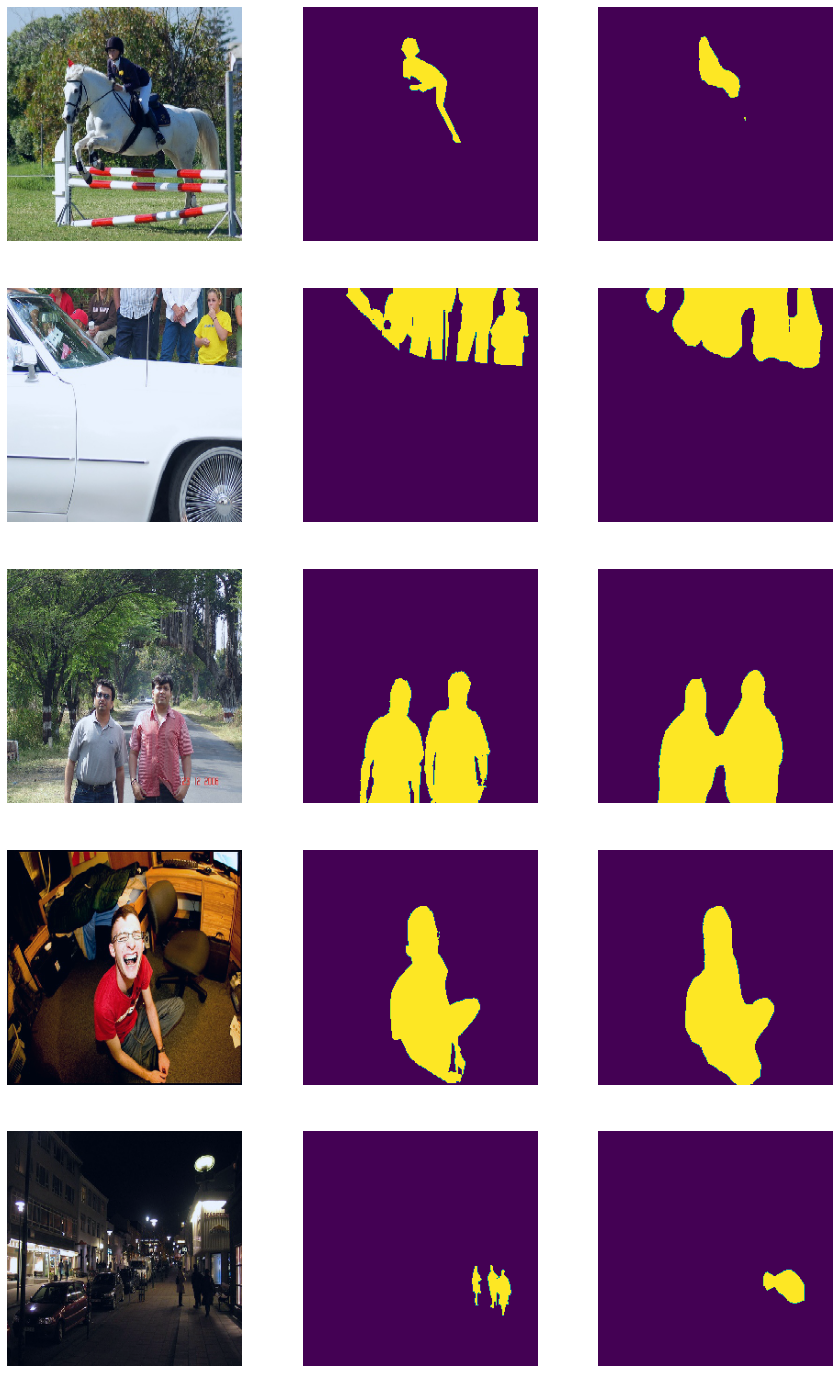

In [98]:
from numpy import random as rng

n_samples = 5

fig, ax = plt.subplots(n_samples,3,figsize=(5*3,5*n_samples))
for row,n in enumerate(rng.permutation(x_test_im.shape[0])[:n_samples]):
    x = x_test_im[n,:] # извлекаем одну картинку
    ax[row][0].axis(False)
    ax[row][0].imshow(x)

    y = y_test[n,:] # извлекаем маску разметки из датасета
    ax[row][1].axis(False)
    ax[row][1].imshow(y)
    
    a = p[n,:] # извлекаем маску из результата
    ax[row][2].axis(False)
    ax[row][2].imshow(a)
    